# Chapter 5. Calculation of diffusion profiles

___Calculate diffusion profiles including: <br>
· One predeposition process (constant source). <br>
· Any number of subsequent drive-in processes (constant dose)___

Q = 1.41e+14 cm-3
Junction depth predeposition: 0.00835 um
Rsheet = 29.431 ohm/sq
Ns: 1.68e+19 cm-3
Total difussion length: 0.0949 um
Junction depth: 0.259 um


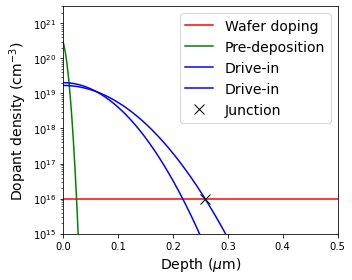

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


DATA_SIZE = 1000   #Size of data
kB = 8.617333e-5
q = 1.6021766e-19 #eV

#Dopant diffusion data
D0 = 10.5 #cm2·s-1
Ea = 3.69 #eV

# Material carrier mobility
mu = 1500 #cm2/V·s

# Wafer doping level
Nwafer = 1e16 #cm-3

# Process data: arrays of temperatures (K) and times (s)
# The first datapoint is for the predeposition step.
# The rest of datapoints are drive-in steps.
# Example: 
#    predeposition (850 ºC, 20 min)
#    drive-in (1000 ºC, 10 min)
#    effect of Al-BSF formation

# Temperatures in C
T_list = np.array([850, 1000, 970], dtype='double')  #ºC
# Times
time_list = np.array([600, 600, 600], dtype='double')  #s
# Surface doping density
Ns = 3e20 #cm-3

### Plotting settings
# Max. depth to plot
depth = 0.5e-4# cm
# Define intermediate profiles to plot
# 1 means that the result of that diffusion step is plotted
plot_profile = [1, 1, 1]

########################
### Calculate profiles
########################

# Temperatures in K 
T_list += 273.15  #K

nSteps = len(T_list)

# Make array with constant base doping profile
Nbase = np.zeros((DATA_SIZE,2))
Nbase[:,0] = np.linspace(0, depth, DATA_SIZE)
Nbase[:,1] = Nwafer

# Make array for profiles calculated
Nx = np.zeros((DATA_SIZE,2))
Nx[:,0] = np.linspace(0, depth, DATA_SIZE)
# Array with depths in microns for plotting
depth_um = np.zeros((DATA_SIZE))
depth_um = Nx[:,0]*1e4

### 1. Predeposition
# First point in list of steps is assumed to be a predeposition
dif_coef = D0*math.exp(-Ea/(kB*T_list[0]))
dif_len = math.sqrt(4*dif_coef*time_list[0])
for x in range(DATA_SIZE):
    Nx[x,1] = Ns*math.erfc(Nx[x,0]/dif_len)

Qload = Ns*dif_len/math.sqrt(math.pi)
x_junc = dif_len*(math.erfc(Nwafer/Ns))**-1
Rsheet = 1/(q*mu*Qload)

# Print results
print("Q = "+f"{Qload:.3}"+" cm-3")
print("Junction depth predeposition: " + f"{x_junc*1e4:.3}"+" um")
print("Rsheet = "+f"{Rsheet:.3f}"+" ohm/sq")

# Plot results
fig = plt.figure(figsize=[5,4], tight_layout=True)
ax = fig.add_subplot()    
ax.set_xlabel('Depth ($\mu$m)', size=14)
ax.set_ylabel('Dopant density (cm$^{-3}$)', size=14)
ax.set_yscale('log')
ax.set_ylim(Nwafer/10, Ns*10)
ax.set_xlim(0, depth*1e4)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

trace, = ax.plot(depth_um, Nbase[:,1], 'r-', label='Wafer doping' )

if plot_profile[0]==1:
    trace, = ax.plot(depth_um, Nx[:,1], 'g-', label='Pre-deposition' )

# 2. Drive-in steps
# 
for x in range(nSteps-1):
    dif_len = 0
    for z in range(x+1):
        dif_coef = D0*math.exp(-Ea/(kB*T_list[z+1]))
        dif_len += dif_coef*time_list[z+1]
    dif_len = 2*math.sqrt(dif_len)
    for y in range(DATA_SIZE):
        Nx[y,1] = (2/math.sqrt(math.pi))*(Qload/dif_len)*math.exp(-(Nx[y,0]/dif_len)**2) 

    surface_N = (2/math.sqrt(math.pi))*(Qload/dif_len)
    x_junc = dif_len*math.sqrt(math.log(surface_N/Nwafer))

        
    if plot_profile[x]==1:
        trace, = ax.plot(depth_um, Nx[:,1], 'b-', label='Drive-in')  

# Plot junction position
trace, = ax.plot(x_junc*1e4, np.interp(x_junc,Nx[:,0],Nx[:,1]) , 'kx', markersize=10, label='Junction')  
# Print results of all drive-in steps
print("Ns: " + f"{surface_N:.3}"+" cm-3")
print("Total difussion length: " + f"{dif_len*1e4:.3}"+" um")
print("Junction depth: " + f"{x_junc*1e4:.3}"+" um")
        
ax.legend(fontsize=14)    

# Save figure, in case it is needed for a nice homework report :-)
plt.savefig("fig_process.png", dpi=300)
